In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
%cd ..

/home/adrish/dark-matter-halos-2


/home/adrish/miniconda3/envs/gromov/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from pathlib import Path
from src.pipeline.pipeline import *
from jax import numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
import optuna

2025-01-13 12:40:49.021229: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
root_path = Path(".")
data_path = root_path / "data"
gen_data_path = root_path / "generated_data_extended"
results_path = root_path / "results" / "cross_validation"

features_and_targets = jnp.load(gen_data_path / "features_and_targets.npz")
subsampled_data = jnp.load(gen_data_path / "kmeans_subsampled_n1_s75.npz")

n_halos = 500

# Generating the train-test split: keep fixed seed of 0
rng = jax.random.PRNGKey(0)
prop_train = 0.75
prop_test = 0.25

n_train = int(n_halos * prop_train)
n_test = n_halos - n_train

train_indices = jax.random.choice(rng, n_halos, [n_train], replace=False)
test_indices = jnp.array(
    list(set(range(n_halos)) - set([ix.item() for ix in list(train_indices)]))
)
np.savetxt(gen_data_path / "train_indices.txt", np.array(train_indices), fmt="%i")
np.savetxt(gen_data_path / "test_indices.txt", np.array(test_indices), fmt="%i")

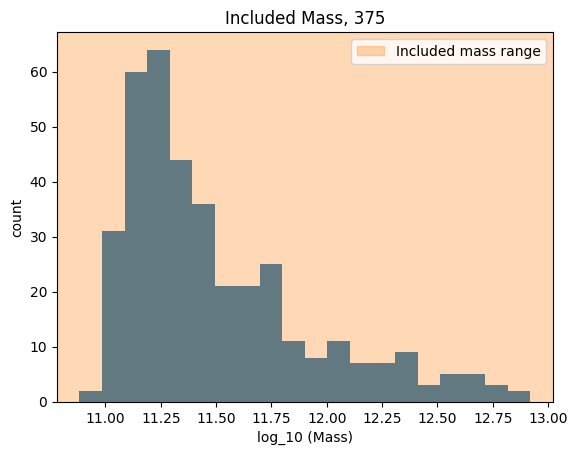

In [4]:
# We'll include mass-slicing so that we can go back to a thin slice if necessary:
mass_range = (-11.1, 101.3)  # set to (-np.inf, np.inf) to include everything
train_log_m = np.log10(features_and_targets["Group_M_Crit200"][train_indices])
train_sliced_mass_ix = train_indices[
    np.argwhere((train_log_m > mass_range[0]) & (train_log_m < mass_range[1]))[:, 0]
]
fig, ax = plt.subplots()
ax: plt.Axes = ax

ax.hist(train_log_m, bins=20)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.fill_betweenx(
    y=[-1, 1e6],
    x1=[mass_range[1], mass_range[1]],
    x2=[mass_range[0], mass_range[0]],
    color="C1",
    alpha=0.3,
    label="Included mass range"
)
ax.set(xlim=xlim, ylim=ylim, title=f"Included Mass, {len(train_sliced_mass_ix)}", xlabel="log_10 (Mass)", ylabel="count")
ax.legend()

In [5]:
t = 0 # k-means trial number
weights_subsampled = subsampled_data["weights"][train_sliced_mass_ix, t]
points_subsampled = subsampled_data["points"][train_sliced_mass_ix, t]
velocities_subsampled = subsampled_data["velocities"][train_sliced_mass_ix, t]

train_stellar_mass = features_and_targets["StellarMass"][train_sliced_mass_ix]
train_labels = jnp.log10(train_stellar_mass * 1e10 / 0.677)  # label by logMstar
train_concentration = features_and_targets["SubhaloC200"][train_sliced_mass_ix]
train_mass = jnp.log10(features_and_targets["Group_M_Crit200"][train_sliced_mass_ix])
train_stellar_metallicity = features_and_targets["StellarMetallicity"][
    train_sliced_mass_ix
]
train_star_formation_rate = features_and_targets["StarFormRate"][train_sliced_mass_ix]


## Stellar Mass

In [6]:
problem_context = ProblemContext(
    points=points_subsampled,
    weights=weights_subsampled,
    velocities=velocities_subsampled,
    masses=train_mass,
    concentrations=train_concentration,
    labels=jnp.log10(
        train_stellar_mass * 1e10 / 0.677
    ),  # label by logMstar (I don't know what this comment means -Dan)
    # labels=train_stellar_metallicity
    # labels=train_star_formation_rate,
)

In [8]:
# Stellar Mass
import optuna
def objective(trial):
    pq = trial.suggest_categorical("pq", [1, 2])
    hyperparametrization = Hyperparametrization(
        rescale_strategy=trial.suggest_categorical("rescale", ["unitless", "dispersion", "none"]),
        p=pq,
        q=pq,
        tau=trial.suggest_float("tau",0, 10),
        alpha_C=trial.suggest_float("alpha_c", 0, 100),
        alpha_M=trial.suggest_float("alpha_m", 0, 100),
        alpha_SLB=trial.suggest_float("alpha_slb", 0, 100),
        n_neighbors=trial.suggest_int("n_neighbors", 2, 100)
    )
    losses, loss_array = get_oat_losses(problem_context, hyperparametrization, inner_pbar=False)
    return np.min(loss_array)

study = optuna.create_study(direction="minimize", storage="sqlite:///db.sqlite3", study_name="covhalo/stellar_mass_test", load_if_exists=True)
study.optimize(objective)

[I 2025-01-13 12:41:14,522] A new study created in RDB with name: covhalo/stellar_mass_test


  0%|          | 0/1 [00:00<?, ?it/s]

(75, 6)


[W 2025-01-13 12:41:20,177] Trial 0 failed with parameters: {'pq': 1, 'rescale': 'unitless', 'tau': 5.874665993559124, 'alpha_c': 33.7848147425543, 'alpha_m': 70.20351654905497, 'alpha_slb': 9.300261867315651, 'n_neighbors': 12} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/adrish/miniconda3/envs/gromov/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_66393/744719269.py", line 15, in objective
    losses, loss_array = get_oat_losses(problem_context, hyperparametrization, inner_pbar=False)
  File "/home/adrish/dark-matter-halos-2/src/pipeline/pipeline.py", line 386, in get_oat_losses
    return loss_pipeline(problem_context, hyperparametrization, oat_validate_knn, pbar, inner_pbar)
  File "/home/adrish/dark-matter-halos-2/src/pipeline/pipeline.py", line 329, in loss_pipeline
    slb_dists = batched_slb_func(
  File "/home/adrish/dark-matter-hal

KeyboardInterrupt: 

  0%|          | 0/2 [00:00<?, ?it/s]

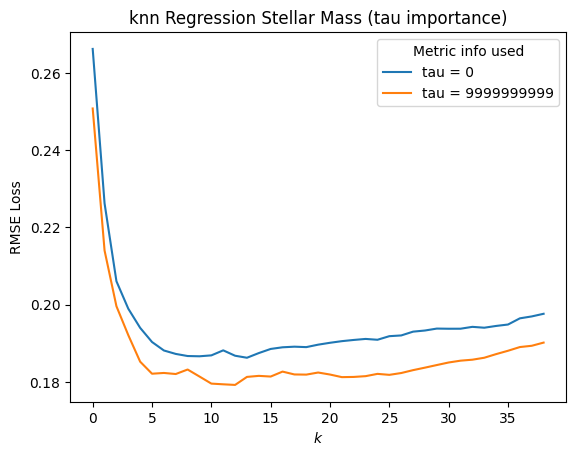

In [7]:
# Label: Stellar Mass

best_hyperparametrization = Hyperparametrization(
    rescale_strategy=["unitless"],
    p=1.,
    q=1.,
    tau=[0, 9999999999],
    alpha_C=14.672736961511486,
    alpha_M=90.9960841116981,
    alpha_SLB=56.26711116650133,
    n_neighbors=np.arange(1, 40)
)

losses, loss_array = get_oat_losses(problem_context, best_hyperparametrization, inner_pbar=False)

fig, ax = plt.subplots()
ax :plt.Axes = ax
ax.plot(loss_array[0], label="tau = 0")
ax.plot(loss_array[1], label="tau = 9999999999")

ax.legend(title="Metric info used")
ax.set(xlabel="$k$", ylabel="RMSE Loss", title="knn Regression Stellar Mass (tau importance)");

## Stellar Metalicity

In [6]:
problem_context = ProblemContext(
    points=points_subsampled,
    weights=weights_subsampled,
    velocities=velocities_subsampled,
    masses=train_mass,
    concentrations=train_concentration,
    # labels=jnp.log10(
    #     train_stellar_mass * 1e10 / 0.677
    # ),  # label by logMstar (I don't know what this comment means -Dan)
    labels=train_stellar_metallicity
    # labels=train_star_formation_rate,
)

In [ ]:
# Stellar Metallicity
import optuna
def objective(trial):
    pq = trial.suggest_categorical("pq", [1, 2])
    hyperparametrization = Hyperparametrization(
        rescale_strategy=trial.suggest_categorical("rescale", ["unitless", "dispersion", "none"]),
        p=pq,
        q=pq,
        tau=trial.suggest_float("tau",0, 10),
        alpha_C=trial.suggest_float("alpha_c", 0, 100),
        alpha_M=trial.suggest_float("alpha_m", 0, 100),
        alpha_SLB=trial.suggest_float("alpha_slb", 0, 100),
        n_neighbors=trial.suggest_int("n_neighbors", 2, 100)
    )
    losses, loss_array = get_oat_losses(problem_context, hyperparametrization, inner_pbar=False)
    return np.min(loss_array)

study = optuna.create_study(direction="minimize", storage="sqlite:///db.sqlite3", study_name="covhalo/stellar_metallicity", load_if_exists=True)
study.optimize(objective)

  0%|          | 0/2 [00:00<?, ?it/s]

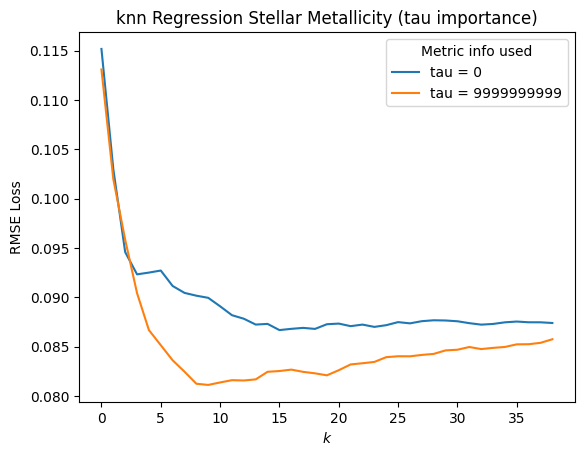

In [7]:
# Label: Stellar Metallicity

best_hyperparametrization = Hyperparametrization(
    rescale_strategy=["unitless"],
    p=1.,
    q=1.,
    tau=[0, 9999999999],
    alpha_C=41.38652023058744,
    alpha_M=94.95040630340328,
    alpha_SLB=70.89754616927755,
    n_neighbors=np.arange(1, 40)
)

losses, loss_array = get_oat_losses(problem_context, best_hyperparametrization, inner_pbar=False)

fig, ax = plt.subplots()
ax :plt.Axes = ax

ax.plot(loss_array[0], label="tau = 0")
ax.plot(loss_array[1], label="tau = 9999999999")
ax.legend(title="Metric info used")
ax.set(xlabel="$k$", ylabel="RMSE Loss", title="knn Regression Stellar Metallicity (tau importance)");

## Star Formation Rate

In [6]:
problem_context = ProblemContext(
    points=points_subsampled,
    weights=weights_subsampled,
    velocities=velocities_subsampled,
    masses=train_mass,
    concentrations=train_concentration,
    # labels=jnp.log10(
    #     train_stellar_mass * 1e10 / 0.677
    # ),  # label by logMstar (I don't know what this comment means -Dan)
    # labels=train_stellar_metallicity
    labels=train_star_formation_rate,
)

In [ ]:
# Star Formation Rate
import optuna
def objective(trial):
    pq = trial.suggest_categorical("pq", [1, 2])
    hyperparametrization = Hyperparametrization(
        rescale_strategy=trial.suggest_categorical("rescale", ["unitless", "dispersion", "none"]),
        p=pq,
        q=pq,
        tau=trial.suggest_float("tau",0, 10),
        alpha_C=trial.suggest_float("alpha_c", 0, 100),
        alpha_M=trial.suggest_float("alpha_m", 0, 100),
        alpha_SLB=trial.suggest_float("alpha_slb", 0, 100),
        n_neighbors=trial.suggest_int("n_neighbors", 2, 100)
    )
    losses, loss_array = get_oat_losses(problem_context, hyperparametrization, inner_pbar=False)
    return np.min(loss_array)

study = optuna.create_study(direction="minimize", storage="sqlite:///db.sqlite3", study_name="covhalo/star_formation", load_if_exists=True)
study.optimize(objective)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

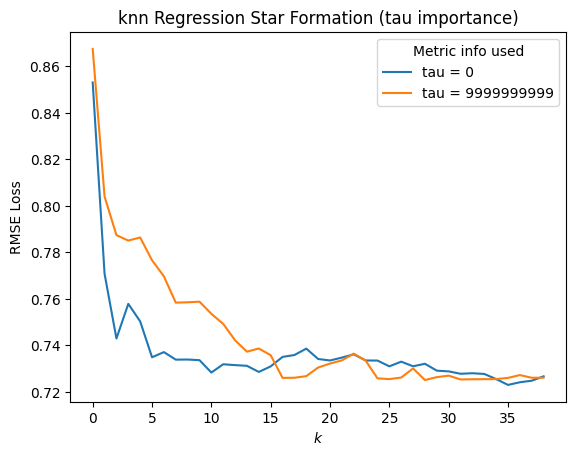

In [7]:
# Label: Star Formation Rate

best_hyperparametrization = Hyperparametrization(
    rescale_strategy=["dispersion"],
    p=2.,
    q=2.,
    tau=[0, 9999999999],
    alpha_C=22.954853753245022,
    alpha_M=94.96140687714441,
    alpha_SLB=14.423051676594431,
    n_neighbors=np.arange(1, 40)
)

losses, loss_array = get_oat_losses(problem_context, best_hyperparametrization, inner_pbar=True)

fig, ax = plt.subplots()
ax :plt.Axes = ax

ax.plot(loss_array[0], label="tau = 0")
ax.plot(loss_array[1], label="tau = 9999999999")
ax.legend(title="Metric info used")
ax.set(xlabel="$k$", ylabel="RMSE Loss", title="knn Regression Star Formation (tau importance)");